### Импорт библиотек


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns

----

### Чтение данных


In [35]:
df = pd.read_csv('Titanic.csv')

----

### Предпросмотр данных и работа с ними


In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


На данном этапе можно убрать следующие данные:

- PassengerID - просто ID пассажира, не может влиять на выживаемость
- Name - уникальное имя пассажира, также не может влиять на его выживаемость
- Embarked - город посадки пассажира, также не может влиять на выживаемость, особенно на больших данных
- Ticket - номер билета пассажира, скорее всего не имеет влияния на выживаемость

In [36]:
df = df.drop('PassengerId', axis=1)
df = df.drop('Name', axis=1)
df = df.drop('Embarked', axis=1)
df = df.drop('Ticket', axis=1)

#### Работа с NaN

Проверим данные на наличие пропущенных значений.

In [ ]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Cabin,687


В качестве результата проверки имеем:

- Cabin - содержит слишком много незаполненных ячеек, попытка заполнения не может быть успешной из-за маленького объема данных

Удалим её для более точной оценки выживаемости:

In [37]:
df = df.drop('Cabin', axis=1)

У нас остается одна колонка не int, переводим:

In [38]:
df['Sex'] = df['Sex'].map({'female': 1, 'male': 0})

----

### Разведочный анализ данных (EDA)


#### Анализ графиков

На так называемом ящике с усами видно, что мужчины в целом старше и имеют больше выбросов по возрасте (крайних значений):

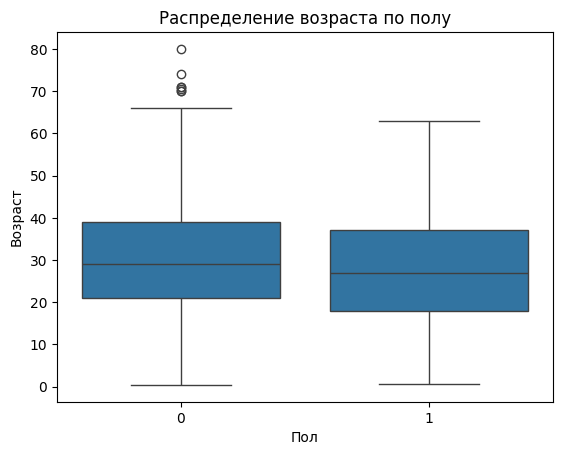

In [12]:
sns.boxplot(x='Sex', y='Age', data=df)
plt.xlabel('Пол')
plt.ylabel('Возраст')
plt.title('Распределение возраста по полу')
plt.show()

...
----------

На графике ниже видно зависимость выживаемости от возраста: у людей среднего возраста выживаемость значительно ниже, чем в группах от 0 до 15 и от 55 до 80 лет, о чем свидетельствует яркий провал в возрастной группе 20 - 50 лет

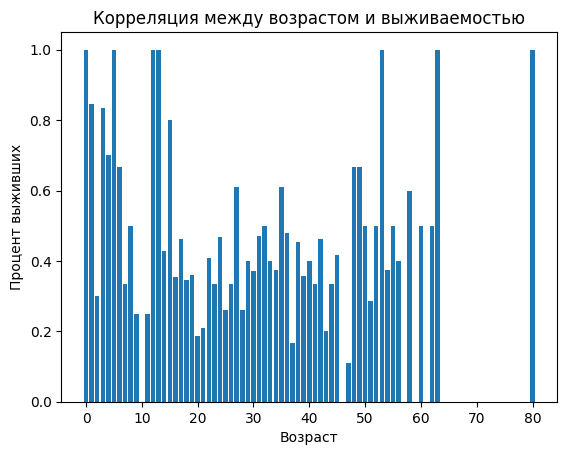

In [13]:
rounded_ages = df['Age'].round()
survival_rates = df.groupby(rounded_ages)['Survived'].mean()
plt.bar(survival_rates.index, survival_rates.values)
plt.xlabel('Возраст')
plt.ylabel('Процент выживших')
plt.title('Корреляция между возрастом и выживаемостью')
plt.show()

...
----------

Главная проблема двух графиков ниже - их интерпретация. Параметр является гибридным, поэтому, например, 1 колонке SibSp может обозначать как супруга, так и брата/сестру. Аналогичная проблема присутствует и в колонке Parch. Еще больше усложняет ситуацию то, что на титанике может быть три поколения одной семьи, или, например, дедушка с внуком, что не будет как либо зачислено в датасете. Поэтому эти колонки отбрасываются для подсчета корреляции возраста.

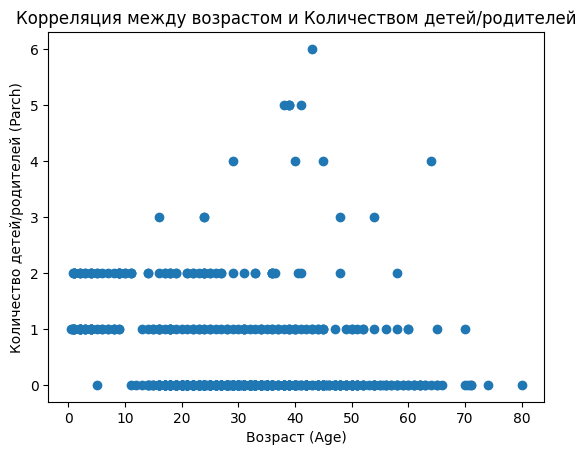

In [14]:
plt.scatter(df['Age'], df['Parch'])
plt.xlabel('Возраст (Age)')
plt.ylabel('Количество детей/родителей (Parch)')
plt.title('Корреляция между возрастом и Количеством детей/родителей')
plt.show()

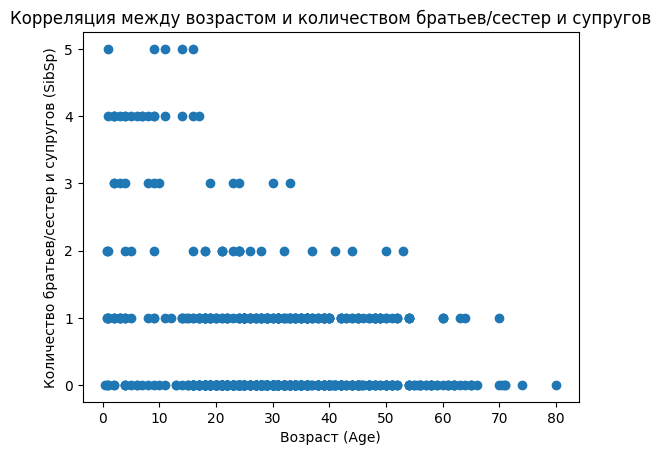

In [15]:
plt.scatter(df['Age'], df['SibSp'])
plt.xlabel('Возраст (Age)')
plt.ylabel('Количество братьев/сестер и супругов (SibSp)')
plt.title('Корреляция между возрастом и количеством братьев/сестер и супругов')
plt.show()

...
----------

#### Модель К-ближайших соседей

На основе графиков мы можем создать модель К-ближайших соседей. Выстраиваем корреляцию возраста с параметрами класса билета, пола и стоимости билета и делаем предсказание для пустых ячеек.

In [39]:
df_train = df[~df['Age'].isnull()]
features = ['Pclass', 'Sex', 'Fare', 'Survived']
model =  KNeighborsRegressor(n_neighbors=5)
model.fit(df_train[features], df_train['Age'])
df_test = df[df['Age'].isnull()]
predicted_age = model.predict(df_test[features])
df.loc[df['Age'].isnull(), 'Age'] = predicted_age

In [ ]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0


In [40]:
X = df.drop(columns=['Survived'])
y = df['Survived']

Присутствует дизбаланс классов

In [ ]:
df['Survived'].value_counts()

,count
Survived,
0,549
1,342


По графику ниже можем заметить сильную корреляцию с колонками Fare, Pclass, Sex и слабую корреляцию с Age и Parch. Корреляция с SibSp практически отсутствует.

In [ ]:
df.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,0.543351,-0.111891,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.131900,-0.357595,0.083081,0.018443,-0.549500
Sex,0.543351,-0.131900,1.000000,-0.132805,0.114631,0.245489,0.182333
Age,-0.111891,-0.357595,-0.132805,1.000000,-0.202555,-0.177871,0.091416
SibSp,-0.035322,0.083081,0.114631,-0.202555,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,0.245489,-0.177871,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.182333,0.091416,0.159651,0.216225,1.000000


In [41]:
df = df.drop('SibSp', axis=1)

----

### Feature Engineering


Добавим новые признаки для улучшения модели:

In [ ]:
# Возрастные группы
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 25, 40, 60, 100], 
                        labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Middle-aged', 'Senior'])

# Категории стоимости
df['FareCategory'] = pd.qcut(df['Fare'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# Признак, указывающий является ли человек ребёнком
df['IsChild'] = (df['Age'] < 18).astype(int)

# Признак, есть ли у человека семья
df['HasFamily'] = (df['Parch'] > 0).astype(int)

# Стоимость на человека
df['Fare_per_person'] = df['Fare'] / (df['Parch'] + 1)

#### Корреляция новых признаков с таргетом

Возрастные группы.

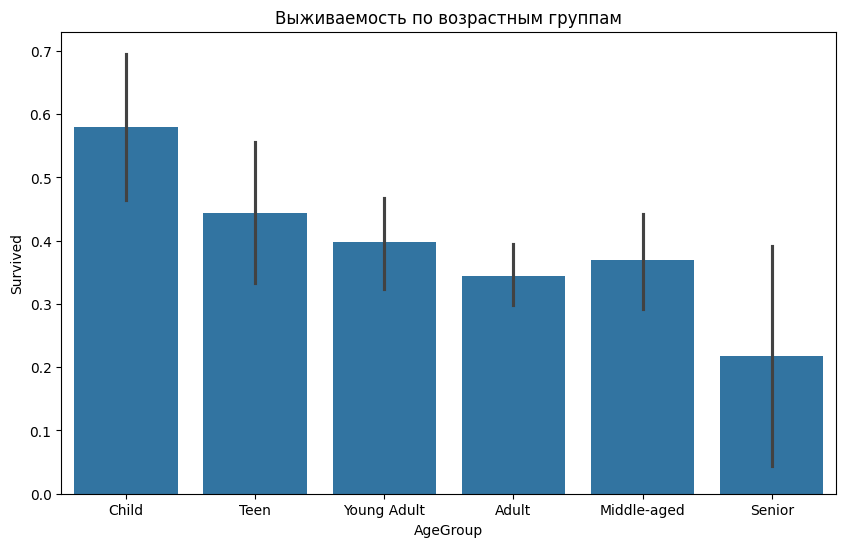

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x='AgeGroup', y='Survived', data=df, order=['Child', 'Teen', 'Young Adult', 'Adult', 'Middle-aged', 'Senior'])
plt.title('Выживаемость по возрастным группам')
plt.show()

Дети (Child) имеют самый высокий уровень выживаемости (~58%), тогда как пожилые (Senior) — самый низкий (~24%). Это подтверждает гипотезу о приоритете спасения детей.

...
----------

Категории стоимости билета

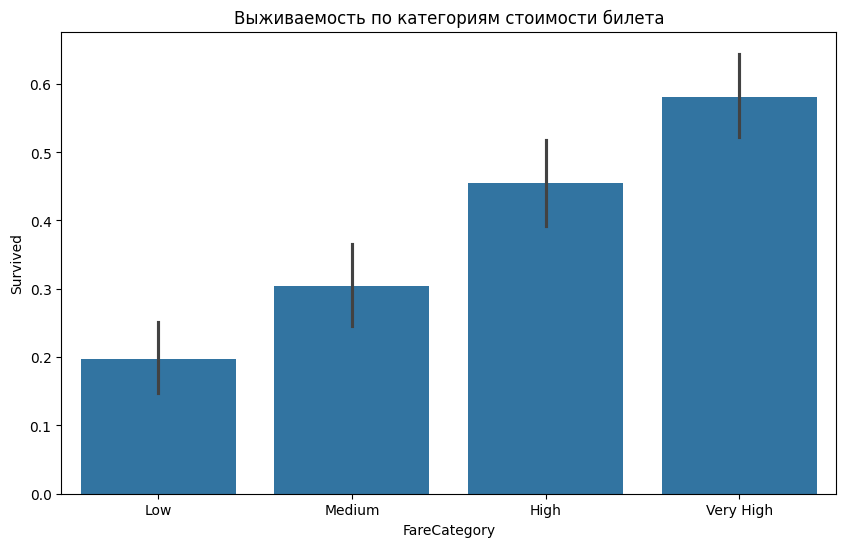

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x='FareCategory', y='Survived', data=df, order=['Low', 'Medium', 'High', 'Very High'])
plt.title('Выживаемость по категориям стоимости билета')
plt.show()

Пассажиры с билетами категории "Very High" выживали в ~58% случаев, тогда как в категории "Low" — только ~20%. Стоимость билета сильно коррелирует с выживаемостью.

...
----------

Наличие семьи

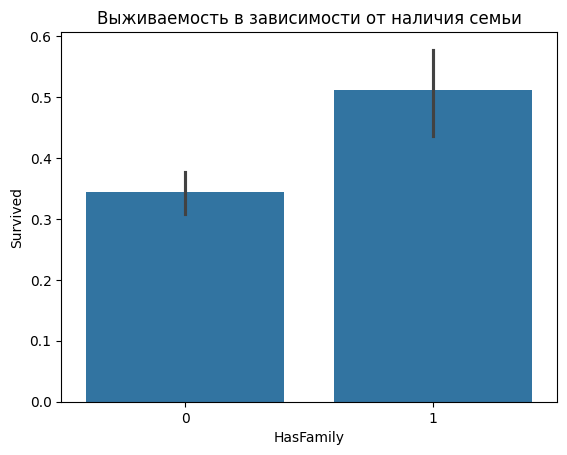

In [15]:
sns.barplot(x='HasFamily', y='Survived', data=df)
plt.title('Выживаемость в зависимости от наличия семьи')
plt.show()

Пассажиры с семьей (HasFamily=1) выживали чаще (~50%), чем одиночки (~33%).

...
----------

#### Feature Importances

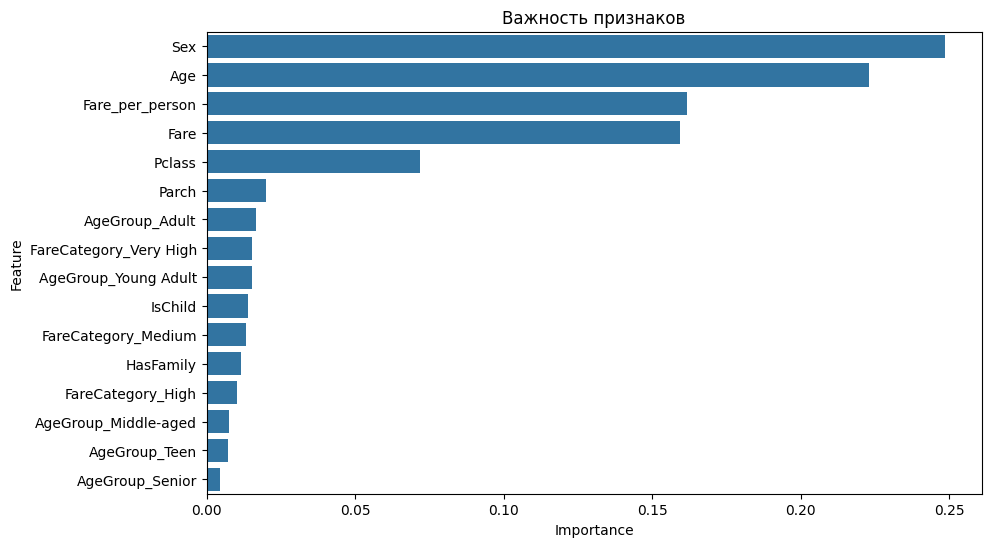

In [ ]:
df = pd.get_dummies(df, columns=['AgeGroup', 'FareCategory'], drop_first=True)

from sklearn.ensemble import RandomForestClassifier

X = df.drop('Survived', axis=1)
y = df['Survived']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Важность признаков')
plt.show()

Наиболее важными признаками оказались:

- Sex (пол),

- Age (возраст),

- Fare и Fare_per_person (стоимость билета/стоимость билета на человека),

- Pclass (класс каюты).

----

### Построение моделей


Теперь у нас есть все данные в таблице, можем строить модели

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [11]:
def get_metrix_of_model(model, epochs, name, X_train, y_train, X_test, y_test):
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
  model.fit(
      X_train, y_train,
      epochs=epochs,
      validation_data=(X_test, y_test)
  )
  loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
  y_pred = (model.predict(X_test) > 0.5).astype(int)
  f1 = f1_score(y_test, y_pred)
  print(f'Модель {name}:')
  print(f'Точность: {accuracy}')
  print(f'F1-мера: {f1}')

In [15]:
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=52
)

...
----------

----

### Нейронные сети

#### Простая полносвязная сеть

In [ ]:
md1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1, 10, "Простая полносвязная сеть", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5408 - loss: 1.4510 - val_accuracy: 0.6633 - val_loss: 0.6646
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6485 - loss: 0.6706 - val_accuracy: 0.6902 - val_loss: 0.6068
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7102 - loss: 0.5985 - val_accuracy: 0.7003 - val_loss: 0.5899
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7139 - loss: 0.5606 - val_accuracy: 0.6970 - val_loss: 0.5913
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6865 - loss: 0.5847 - val_accuracy: 0.7071 - val_loss: 0.5901
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6918 - loss: 0.5960 - val_accuracy: 0.7104 - val_loss: 0.5764
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7433 - loss: 0.5583 - val_accuracy: 0.7239 - val_loss: 0.5779
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7124 - loss: 0.5679 - val_accuracy: 0.7037 - val_loss: 0.6133
Epo

...
----------

#### Сеть с дропаутом

In [22]:
md2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md2, 10, "Сеть с дропаутом", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5420 - loss: 1.7261 - val_accuracy: 0.6269 - val_loss: 1.3713
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6506 - loss: 1.2128 - val_accuracy: 0.6866 - val_loss: 0.9871
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6217 - loss: 0.9287 - val_accuracy: 0.6269 - val_loss: 0.9022
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6583 - loss: 0.8206 - val_accuracy: 0.6940 - val_loss: 0.8228
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6845 - loss: 0.7376 - val_accuracy: 0.6866 - val_loss: 0.7156
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6240 - loss: 0.7273 - val_accuracy: 0.6343 - val_loss: 0.7221
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6608 - loss: 0.7491 - val_accuracy: 0.6343 - val_loss: 0.7666
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6585 - loss: 0.7025 - val_accuracy: 0.7015 - val_loss: 0.6356
Epo

...
----------

#### Сеть с рекуррентным слоем

In [ ]:
md3 = keras.Sequential([
    layers.LSTM(64, input_shape=(X_train.shape[1], 1)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
get_metrix_of_model(md3, 10, "Сеть с рекуррентным слоем", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4845 - loss: 0.6996 - val_accuracy: 0.6700 - val_loss: 0.6324
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6491 - loss: 0.6283 - val_accuracy: 0.6700 - val_loss: 0.6176
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6711 - loss: 0.5983 - val_accuracy: 0.6532 - val_loss: 0.6160
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6810 - loss: 0.5912 - val_accuracy: 0.6599 - val_loss: 0.6179
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6634 - loss: 0.6038 - val_accuracy: 0.6700 - val_loss: 0.6200
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6663 - loss: 0.5912 - val_accuracy: 0.6498 - val_loss: 0.6125
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6781 - loss: 0.5950 - val_accuracy: 0.6667 - val_loss: 0.6134
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6803 - loss: 0.5817 - val_accuracy: 0.6667 - val_loss: 0.6091
Ep

...
----------

Лучшая F1-мера у простой полносвязной сети, поэксперементируем с топологией сети:

In [ ]:
md1_1 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_1, 10, "128-64-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5847 - loss: 1.6029 - val_accuracy: 0.6716 - val_loss: 0.6533
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6916 - loss: 0.6026 - val_accuracy: 0.6940 - val_loss: 0.5942
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7078 - loss: 0.5734 - val_accuracy: 0.7015 - val_loss: 0.5886
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6810 - loss: 0.5625 - val_accuracy: 0.6269 - val_loss: 0.6065
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6884 - loss: 0.5932 - val_accuracy: 0.6716 - val_loss: 0.5880
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6726 - loss: 0.5587 - val_accuracy: 0.6866 - val_loss: 0.5788
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7384 - loss: 0.5409 - val_accuracy: 0.6716 - val_loss: 0.5721
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7146 - loss: 0.5829 - val_accuracy: 0.7164 - val_loss: 0.6274
Epo

In [ ]:
md1_2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2, 10, "64-128-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6112 - loss: 1.0392 - val_accuracy: 0.6716 - val_loss: 0.6243
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6620 - loss: 0.6397 - val_accuracy: 0.6791 - val_loss: 0.5793
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6806 - loss: 0.6061 - val_accuracy: 0.6716 - val_loss: 0.5875
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6781 - loss: 0.5933 - val_accuracy: 0.6866 - val_loss: 0.5783
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7178 - loss: 0.5483 - val_accuracy: 0.6940 - val_loss: 0.6042
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6969 - loss: 0.5638 - val_accuracy: 0.7015 - val_loss: 0.5729
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7253 - loss: 0.5574 - val_accuracy: 0.7164 - val_loss: 0.6116
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7326 - loss: 0.5560 - val_accuracy: 0.7015 - val_loss: 0.5693
Epo

In [ ]:
md1_3 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_3, 10, "32-64-32-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5689 - loss: 0.9400 - val_accuracy: 0.6642 - val_loss: 0.6436
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6962 - loss: 0.5988 - val_accuracy: 0.6866 - val_loss: 0.6177
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7131 - loss: 0.5514 - val_accuracy: 0.6343 - val_loss: 0.6285
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6410 - loss: 0.5984 - val_accuracy: 0.6940 - val_loss: 0.6207
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6790 - loss: 0.5859 - val_accuracy: 0.6716 - val_loss: 0.5992
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6902 - loss: 0.5832 - val_accuracy: 0.6418 - val_loss: 0.6489
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7112 - loss: 0.5795 - val_accuracy: 0.6791 - val_loss: 0.5752
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7163 - loss: 0.5671 - val_accuracy: 0.6791 - val_loss: 0.5780
Epo

...
----------

Лучшие метрики показала модель с топологией 64-128-1, можем также посмотреть на данную модель с разным количеством нейронов:

In [ ]:
md1_2_1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2_1, 10, "64-256-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5892 - loss: 0.8617 - val_accuracy: 0.6567 - val_loss: 0.6874
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6533 - loss: 0.6513 - val_accuracy: 0.6567 - val_loss: 0.7868
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6889 - loss: 0.6682 - val_accuracy: 0.6716 - val_loss: 0.6664
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6763 - loss: 0.6357 - val_accuracy: 0.6343 - val_loss: 0.6480
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7162 - loss: 0.5618 - val_accuracy: 0.6567 - val_loss: 0.5900
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6732 - loss: 0.6228 - val_accuracy: 0.6791 - val_loss: 0.7577
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6925 - loss: 0.6651 - val_accuracy: 0.7015 - val_loss: 0.7876
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7061 - loss: 0.6114 - val_accuracy: 0.7239 - val_loss: 0.5641
Epo

In [ ]:
md1_2_2 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2_2, 10, "128-256-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6024 - loss: 1.2015 - val_accuracy: 0.5597 - val_loss: 0.6635
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6706 - loss: 0.6811 - val_accuracy: 0.4478 - val_loss: 0.7433
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5905 - loss: 0.6627 - val_accuracy: 0.6269 - val_loss: 0.6927
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7239 - loss: 0.5733 - val_accuracy: 0.6940 - val_loss: 0.6077
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6766 - loss: 0.5945 - val_accuracy: 0.6866 - val_loss: 0.6135
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7267 - loss: 0.5711 - val_accuracy: 0.6791 - val_loss: 0.7288
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7354 - loss: 0.5964 - val_accuracy: 0.6940 - val_loss: 0.5956
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7544 - loss: 0.5111 - val_accuracy: 0.7388 - val_loss: 0.6430
Epo

In [ ]:
md1_2_3 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2_3, 10, "128-512-1", X_train, y_train, X_test, y_test)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6152 - loss: 1.1760 - val_accuracy: 0.5224 - val_loss: 0.8068
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6681 - loss: 0.6549 - val_accuracy: 0.6940 - val_loss: 0.6693
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6807 - loss: 0.6149 - val_accuracy: 0.6493 - val_loss: 0.7445
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6954 - loss: 0.6399 - val_accuracy: 0.6418 - val_loss: 0.7873
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7052 - loss: 0.6050 - val_accuracy: 0.6866 - val_loss: 0.6422
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7371 - loss: 0.5714 - val_accuracy: 0.7388 - val_loss: 0.5343
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7546 - loss: 0.4838 - val_accuracy: 0.7164 - val_loss: 0.5305
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7006 - loss: 0.5997 - val_accuracy: 0.6940 - val_loss: 0.6490
Ep

----

### Линейные модели

#### Логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

logreg_params = {'C': [0.01, 0.1, 1], 'penalty': ['l2']}
logreg_grid = GridSearchCV(LogisticRegression(random_state=52, max_iter=1000), logreg_params, cv=5)
logreg_grid.fit(X_train, y_train)
linear_model = logreg_grid.best_estimator_

y_pred_linear = linear_model.predict(X_test)
print("Линейная модель (логистическая регрессия):")
print("Точность:", accuracy_score(y_test, y_pred_linear))
print("F1-мера:", f1_score(y_test, y_pred_linear))

Линейная модель (логистическая регрессия):
Точность: 0.835820895522388
F1-мера: 0.7441860465116279


...
----------

#### Ridge-классификация

In [19]:
from sklearn.linear_model import RidgeClassifier

ridge_model = RidgeClassifier(random_state=52)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)
print("\nЛинейная модель (Ridge):")
print("Точность:", accuracy_score(y_test, y_pred_ridge))
print("F1-мера:", f1_score(y_test, y_pred_ridge))


Линейная модель (Ridge):
Точность: 0.8059701492537313
F1-мера: 0.6976744186046512


...
----------

#### с SGD-обучением

In [20]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss='log_loss', random_state=52)
sgd_model.fit(X_train, y_train)

y_pred_sgd = sgd_model.predict(X_test)
print("\nЛинейная модель (SGD):")
print("Точность:", accuracy_score(y_test, y_pred_sgd))
print("F1-мера:", f1_score(y_test, y_pred_sgd))


Линейная модель (SGD):
Точность: 0.7611940298507462
F1-мера: 0.5294117647058824


...
----------

----

### Деревья

#### Дерево решений

In [21]:
from sklearn.tree import DecisionTreeClassifier

tree_params = {'max_depth': [3, 5, None], 'min_samples_split': [2, 5]}
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=52), tree_params, cv=5)
tree_grid.fit(X_train, y_train)
tree_model = tree_grid.best_estimator_

y_pred_tree = tree_model.predict(X_test)
print("\nДерево решений:")
print("Точность:", accuracy_score(y_test, y_pred_tree))
print("F1-мера:", f1_score(y_test, y_pred_tree))


Дерево решений:
Точность: 0.8283582089552238
F1-мера: 0.7228915662650602


...
----------

#### Случайный лес

In [22]:
from sklearn.ensemble import RandomForestClassifier

forest_params = {'n_estimators': [100, 200], 'max_depth': [5, 7]}
forest_grid = GridSearchCV(RandomForestClassifier(random_state=52), forest_params, cv=5)
forest_grid.fit(X_train, y_train)
forest_model = forest_grid.best_estimator_

y_pred_forest = forest_model.predict(X_test)
print("\nСлучайный лес (Random Forest):")
print("Точность:", accuracy_score(y_test, y_pred_forest))
print("F1-мера:", f1_score(y_test, y_pred_forest))


Случайный лес (Random Forest):
Точность: 0.8507462686567164
F1-мера: 0.7619047619047619


...
----------

#### Градиентный бустинг от Scikit-learn

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

sklearn_boost_params = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}
sklearn_boost_grid = GridSearchCV(GradientBoostingClassifier(random_state=52), sklearn_boost_params, cv=5)
sklearn_boost_grid.fit(X_train, y_train)
sklearn_boost_model = sklearn_boost_grid.best_estimator_

y_pred_sklearn_boost = sklearn_boost_model.predict(X_test)
print("\nГрадиентный бустинг (Scikit-learn):")
print("Точность:", accuracy_score(y_test, y_pred_sklearn_boost))
print("F1-мера:", f1_score(y_test, y_pred_sklearn_boost))


Градиентный бустинг (Scikit-learn):
Точность: 0.8445945945945946
F1-мера: 0.7850467289719626


...
----------

----

### Модификации градиентного бустинга

#### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 5]}
xgb_grid = GridSearchCV(XGBClassifier(random_state=52), xgb_params, cv=5)
xgb_grid.fit(X_train, y_train)
boost_model = xgb_grid.best_estimator_

y_pred_boost = boost_model.predict(X_test)
print("\nГрадиентный бустинг (XGBoost):")
print("Точность:", accuracy_score(y_test, y_pred_boost))
print("F1-мера:", f1_score(y_test, y_pred_boost))


Градиентный бустинг (XGBoost):
Точность: 0.831081081081081
F1-мера: 0.7663551401869159


...
----------

#### CatBoost

In [57]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(iterations=300, silent=True, random_state=52)
catboost_model.fit(X_train, y_train)

y_pred_catboost = catboost_model.predict(X_test)
print("\nГрадиентный бустинг (CatBoost):")
print("Точность:", accuracy_score(y_test, y_pred_catboost))
print("F1-мера:", f1_score(y_test, y_pred_catboost))


Градиентный бустинг (CatBoost):
Точность: 0.8656716417910447
F1-мера: 0.7906976744186046


...
----------

#### LightGBM

In [30]:
from lightgbm import LGBMClassifier

lgbm_params = {'n_estimators': [100, 200], 'max_depth': [3, 5]}
lgbm_grid = GridSearchCV(LGBMClassifier(random_state=52), lgbm_params, cv=5)
lgbm_grid.fit(X_train, y_train)
lgbm_model = lgbm_grid.best_estimator_

y_pred_lgbm = lgbm_model.predict(X_test)
print("\nГрадиентный бустинг (LightGBM):")
print("Точность:", accuracy_score(y_test, y_pred_lgbm))
print("F1-мера:", f1_score(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 236, number of negative: 369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 605, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390083 -> initscore=-0.446965
[LightGBM] [Info] Start training from score -0.446965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Градиентный бустинг (LightGBM):
Точность: 0.8507462686567164
F1-мера: 0.7777777777777778


...
----------

----

#### Итоговый свод метрик

Нейронная сеть (128-512-1):
- Точность: 0.8208954930305481
- F1-мера: 0.7209302325581395

Линейная модель (Логистическая регрессия):
- Точность: 0.835820895522388
- F1-мера: 0.7441860465116279

Линейная модель (Ridge):
- Точность: 0.8059701492537313
- F1-мера: 0.6976744186046512

Линейная модель (SGD):
- Точность: 0.7611940298507462
- F1-мера: 0.5294117647058824

Деревья (Дерево решений):
- Точность: 0.8283582089552238
- F1-мера: 0.7228915662650602

Деревья (Случайный лес):
- Точность: 0.8507462686567164
- F1-мера: 0.7619047619047619

Деревья (Scikit-learn):
- Точность: 0.8445945945945946
- F1-мера: 0.7850467289719626

Градиентный бустинг (XGBoost):
- Точность: 0.831081081081081
- F1-мера: 0.7663551401869159

Градиентный бустинг (CatBoost):
- Точность: 0.8656716417910447
- F1-мера: 0.7906976744186046

Градиентный бустинг (LightGBM):
- Точность: 0.8507462686567164
- F1-мера: 0.7777777777777778

----

#### Кросс-валидация

Лучшие метрики показала модель CatBoost (современная оптимизированная реализация градиентного бустинга с автоматической обработкой категориальных признаков) 


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np

kFold = StratifiedKFold(n_splits=6, shuffle=True, random_state=52)

f1_scores = []
accuracies = []
reports = []
matrices = []

for fold_idx, (train_index, test_index) in enumerate(kFold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = CatBoostClassifier(
        iterations=300,
        silent=True,
        random_state=52
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    
    accuracies.append(acc)
    f1_scores.append(f1)
    reports.append(report)
    matrices.append(matrix)
    
    print(f'\nФолд {fold_idx + 1}:')
    print(f'Точность: {acc:.4f}')
    print(f'F1-мера: {f1:.4f}')
    print('Classification Report:')
    print(report)
    print('Confusion Matrix:')
    print(matrix)

print('\nИтоговые средние метрики:')
print(f'Средняя точность: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')
print(f'Средняя F1-мера: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}')


Фолд 1:
Точность: 0.8322
F1-мера: 0.7619
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        92
           1       0.83      0.70      0.76        57

    accuracy                           0.83       149
   macro avg       0.83      0.81      0.82       149
weighted avg       0.83      0.83      0.83       149

Confusion Matrix:
[[84  8]
 [17 40]]

Фолд 2:
Точность: 0.8389
F1-мера: 0.7692
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88        92
           1       0.85      0.70      0.77        57

    accuracy                           0.84       149
   macro avg       0.84      0.81      0.82       149
weighted avg       0.84      0.84      0.84       149

Confusion Matrix:
[[85  7]
 [17 40]]

Фолд 3:
Точность: 0.8255
F1-мера: 0.7500
Classification Report:
              precision    recall  f1-score   support

           0       0.8

...
----------

#### Результаты

Кросс валидация показала следующие результаты с точки зрения эффективности модели:
- 1 Фолд: Модель предсказала 84 погибшего верно, отнеся 8 к неправильному классу. Также модель предсказала 17 выживших верно и отнесла 40 к неправильному классу
- 2 Фолд: Модель предсказала 85 погибших верно, отнеся 7 к неправильному классу. Также модель предсказала 17 выживших верно и отнесла 40 к неправильному классу
- 3 Фолд: Модель предсказала 84 погибших верно, отнеся 8 к неправильному классу. Также модель предсказала 18 выжившего верно и отнесла 39 к неправильному классу
- 4 Фолд: Модель предсказала 87 погибших верно, отнеся 4 к неправильному классу. Также модель предсказала 16 выжившего верно и отнесла 41 к неправильному классу
- 5 Фолд: Модель предсказала 83 погибших верно, отнеся 8 к неправильному классу. Также модель предсказала 19 выжившего верно и отнесла 38 к неправильному классу
- 6 Фолд: Модель предсказала 83 погибших верно, отнеся 8 к неправильному классу. Также модель предсказала 16 выжившего верно и отнесла 41 к неправильному классу

Ключевые наблюдения по фолдам:
- Интерпретация матриц ошибок:

    - Класс 0 (погибшие): Во всех фолдах модель корректно предсказывает 83-91% случаев (например, в Фолде 4: 87 правильных предсказаний против 4 ошибочных).

    - Класс 1 (выжившие): Точность ниже — 67-72% (в Фолде 1: 40 верных предсказаний против 17 ошибок). Это указывает на дисбаланс классов.

- Средние метрики:

    - Точность: 0.836 ± 0.015 — стабильность на уровне ~83%.

    - F1-мера: 0.766 ± 0.021 — умеренное качество, но есть потенциал для улучшения.

- Влияние размера датасета:

    - Объем данных мал для глубокого обучения, но достаточен для CatBoost, который устойчив к шуму и хорошо работает на небольших выборках.



----

### Итоги


<b>Вывод:</b>    Проделаны комплексный обзор даты с дозаполнением пустых ячеек методом K ближайших соседей, Feature Engineering и Feature Importances. Был проведен 21 эксперимент с целью найти наиболее эффективную модель. Модель CatBoost, показавшая наилучший результат, была подвергнута тестированию на шести фолдах и продемонстрировала стабильную работу, путём низкого разброса метрик между фолдами, но столкнулась с трудностями в предсказании выживших. Главной проблемой оказался не столько объем данных, сколько их несбалансированность и сложность паттернов для данного класса. При правильной настройке модель может улучшить F1-меру до 0.8+. Однако, не будь данная модель устойчива к шуму и не будь она так хороша на маленьких выборках, то можно было бы исключить легкореализуемость любых попыток точного предсказания из-за флуктуций в дате, которые не невелируются ее объемом.